In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

import numpy as np

In [2]:
dataset = Planetoid(root='prob_data/Planetoid', name='Cora', transform=NormalizeFeatures())

Get some information about dataset

In [3]:
print(f'Number of graphs: {len(dataset)}')

Number of graphs: 1


In [4]:
print(f'Number of features {dataset.num_features}')

Number of features 1433


In [5]:
print(f'Number of classes {dataset.num_classes}')

Number of classes 7


In [6]:
data = dataset[0]

In [7]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [8]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [9]:
print(f'Number of edges: {data.num_edges}')

Number of edges: 10556


In [10]:
print(f'Number of training nodes: {data.train_mask.sum()}')

Number of training nodes: 140


In [11]:
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Training node label rate: 0.05


In [12]:
print(f'Is undirected: {data.is_undirected()}')

Is undirected: True


In [13]:
print(data.x.shape)

torch.Size([2708, 1433])


In [14]:
data.x[0][:50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [15]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

# Graph Neural Network for Node Classification

In [16]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [17]:
class GCN(torch.nn.Module):

    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Init the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First message passing layers (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second message passing layers
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Out layer
        x = F.softmax(self.out(x), dim=1)
        return x





In [18]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [19]:
class RegularNN(torch.nn.Module):

    def __init__(self, hidden_channels):
        super(RegularNN, self).__init__()
        torch.manual_seed(42)

        # Init the layers
        self.fc1 = Linear(dataset.num_features, hidden_channels)
        self.fc2 = Linear(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        # First fully connected layers
        x = self.fc1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second fully connected layers
        x = self.fc2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Out layers
        x = F.softmax(self.out(x), dim=1)

        return x

In [20]:
regular_model = RegularNN(hidden_channels=16)
print(regular_model)

RegularNN(
  (fc1): Linear(in_features=1433, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


# Train and evaluate

Graph model training <br>
Init model

In [21]:
model  = GCN(hidden_channels=16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
# Itit optimizer and criterion
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()

In [23]:
def train(model):
    model.train()
    optimizer.zero_grad()
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)
    # Use only nodes with labels avaliable for loss calculation --> mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [24]:
def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    # Use the class with highest probobility
    pred = out.softmax(dim=1).detach().numpy()
    # Check against ground-truth labels
    test_correct = np.argmax(pred[data.test_mask], axis=1) == data.y[data.test_mask]
    # Derive ratio of correct predictions
    test_acc  = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [25]:
epochs = 1001

losses = []

for epoch in range(epochs):
    loss = train(model)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss {loss:.4f}')


Epoch: 0, loss 1.9461
Epoch: 100, loss 1.8616
Epoch: 200, loss 1.7218
Epoch: 300, loss 1.6939
Epoch: 400, loss 1.6403
Epoch: 500, loss 1.5353
Epoch: 600, loss 1.4883
Epoch: 700, loss 1.4557
Epoch: 800, loss 1.3895
Epoch: 900, loss 1.3847
Epoch: 1000, loss 1.3420


Train loss visualization

<Axes: >

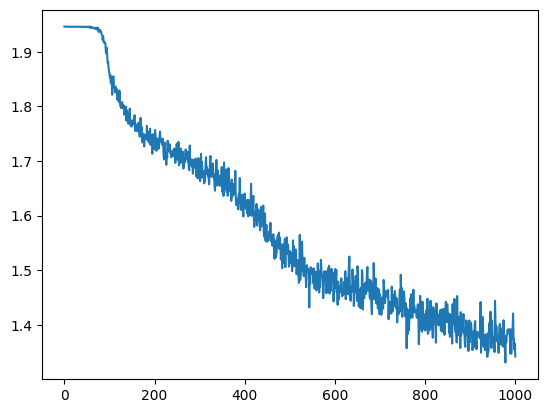

In [26]:
import seaborn as sns

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
plt = sns.lineplot(losses_float)
plt

In [27]:
print(f'Test accuracy: {test(model)}')

Test accuracy: 0.732


# Train regular NN

In [28]:
def train_gnn(model):
    model.train()
    optimizer.zero_grad()
    # Use all data as input, because all nodes have node features
    out = model(data.x)
    # Use only nodes with labels avaliable for loss calculation --> mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [29]:
def test(model):
    model.eval()
    out = model(data.x)
    # Use the class with highest probobility
    pred = out.softmax(dim=1).detach().numpy()
    # Check against ground-truth labels
    test_correct = np.argmax(pred[data.test_mask], axis=1) == data.y[data.test_mask]
    # Derive ratio of correct predictions
    test_acc  = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [30]:
regular_model = RegularNN(hidden_channels=16)

In [31]:
epochs = 1001

losses = []

for epoch in range(epochs):
    loss = train_gnn(regular_model)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss {loss:.4f}')

Epoch: 0, loss 1.9452
Epoch: 100, loss 1.9461
Epoch: 200, loss 1.9467
Epoch: 300, loss 1.9466
Epoch: 400, loss 1.9453
Epoch: 500, loss 1.9464
Epoch: 600, loss 1.9461
Epoch: 700, loss 1.9458
Epoch: 800, loss 1.9464
Epoch: 900, loss 1.9463
Epoch: 1000, loss 1.9478


<Axes: >

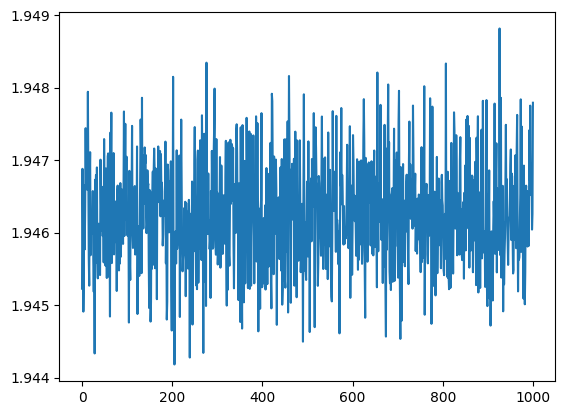

In [32]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
plt = sns.lineplot(losses_float)
plt

In [33]:
print(f'Test accuracy: {test(regular_model)}')

Test accuracy: 0.144
